# Question 2

# Part 1
## Logistion Regression

In [11]:
import pandas as pd
import numpy as np
import sys

csv_path = 'AdmissionDataset/data.csv'#raw_input("Enter path to input CSV file: ")
dataset = pd.read_csv(csv_path)

dataset.drop(dataset.columns[[0]], axis=1, inplace=True)

thresh_range = []
Label = dataset.keys()[7]
thresh_range.append(np.min(dataset['Chance of Admit '])-0.01)
for thresh in np.unique(dataset['Chance of Admit ']):
    thresh_range.append(thresh)
thresh_range.append(np.max(dataset['Chance of Admit '])+0.01)

thresh = np.median( np.array(dataset[Label]) )
dataset.loc[dataset['Chance of Admit '] > thresh, Label] = 1
dataset.loc[dataset['Chance of Admit '] <= thresh, Label] = 0

#split data into train data and validation data
splitted = np.split(dataset, [int(.8 * len(dataset.index))])
train_data = splitted[0]
validation_data = splitted[1]

dataset.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,317,103,2,2.5,2.0,8.15,0,0.0
1,319,108,3,3.0,3.5,8.54,1,0.0
2,322,110,3,3.5,2.5,8.67,1,1.0
3,326,113,5,4.5,4.0,9.40,1,1.0
4,319,106,3,3.5,2.5,8.33,1,1.0


In [12]:
Attributes = dataset.keys()[[0,1,2,3,4,5,6]]
Label = dataset.keys()[7]

In [13]:
for att in Attributes:
    mean = np.mean(train_data[att].values)
    std = np.std(train_data[att].values)
    train_data[att] = (train_data[att]-mean)/(std)
    
for att in Attributes:
    mean = np.mean(validation_data[att].values)
    std = np.std(validation_data[att].values)
    validation_data[att] = (validation_data[att]-mean)/(std)

In [14]:
att_data = train_data[Attributes]
label_data = train_data[Label]

X = att_data.values
Y = label_data.values
extra_col = np.ones([X.shape[0],1])
X = np.concatenate((extra_col,X),axis=1)

m = len(train_data)
n = len(Attributes)

theta = np.zeros([1,n+1])

def h(X):
#     print x
#     print theta_t
    return 1.0/(1 + np.exp(-np.dot(X, theta.T)))

In [15]:
def gradient(X):
    temp = h(X) - Y.reshape(X.shape[0], -1) 
    return np.dot(temp.T, X) 

learning_rate = 0.001
def gradient_decent(X):
    
    global theta
    for i in range(1000):
        
        theta = theta - (learning_rate * gradient(X))
#         print theta
        
# print theta
# print ''
gradient_decent(X)
# print ''
print theta

[[ 0.31054231  1.4626026  -0.19703308  0.80484118  0.37641246  0.31263914
   2.2672417   0.8845926 ]]


In [16]:
def predict(X):
    pred_prob = h(X) 
    return pred_prob


def calculate_performance(validation_data, thresh=thresh):
    
    att_data = validation_data[Attributes]
    label_data = validation_data[Label]

    X = att_data.values
    Y = label_data.values
    extra_col = np.ones([X.shape[0],1])
    X = np.concatenate((extra_col,X),axis=1)
    
    y_predicted = predict(X)
    y_actual = Y
    
    TP, TN, FP, FN = 0, 0, 0, 0
    i = 0
    for index, row in validation_data.iterrows():
        if y_predicted[i] > thresh:
            if row[Label] > thresh:
                TP += 1
            else:
                FP += 1
        else:
            if row[Label] <= thresh:
                TN += 1
            else:
                FN += 1
        i += 1
    
    accuracy = float(TP+TN)/(TP+FP+TN+FN)
    precision = 0
    if TP+FP != 0:
        precision = float(TP)/(TP+FP)
    recall = 0
    if TP+FN != 0:
        recall = float(TP)/(TP+FN)
    return accuracy, precision, recall


a,p,r = calculate_performance(validation_data)
print('Accuracy = '+str(a))
print('Recall = '+str(r))
print('Precision = '+str(p))

Accuracy = 0.811111111111
Recall = 0.755555555556
Precision = 0.85


# Part 2
## Comparison with KNN

In [17]:
from heapq import *
from math import sqrt

def heappeek(heap):
    largest = heappop(heap)
    heappush(heap, largest)
    return largest[0]

def k_nearest_majority(dist_list, k):
    max_heap = []

    i = 0
    while i < k:
        heappush( max_heap, (dist_list[i][0], dist_list[i][1]) )
        i += 1

    while i < len(dist_list):
        if dist_list[i][0] > heappeek(max_heap):
            heappop(max_heap)
            heappush(max_heap, (dist_list[i][0], dist_list[i][1]))
        i += 1

    count = {}
    for value in np.unique(dataset[Label]):
        count[value] = 0

    try:
        while True:
            largest = heappop(max_heap)
            count[largest[1]] += 1
    except IndexError:
        pass

    max_val = None
    max_count = 0
    for value in count.keys():
        if count[value] > max_count:
            max_val = value
            max_count = count[value]

    return max_val


def euclidean_nearest(inst, k):
    distances = []
    op = 0
    for index, row in train_data.iterrows():
        dist = 0.0
        for att in Attributes:
            dist += ( row[att] - inst[att] ) ** 2
        dist = sqrt(dist)
        distances.append((-1*dist, row[Label]))

    op = k_nearest_majority(distances, k)

    return op


def KNN_classifier(new_data, measure, k, thresh=thresh):

    predictions = []

    if measure == 'euclidean':
        for index, row in new_data.iterrows():
            predictions.append(euclidean_nearest(row, k))

    TP, TN, FP, FN = 0, 0, 0, 0
    i = 0
    for index, row in new_data.iterrows():
        if predictions[i] > thresh:
            if row[Label] > thresh:
                TP += 1
            else:
                FP += 1
        else:
            if row[Label] <= thresh:
                TN += 1
            else:
                FN += 1
        i += 1
    
    accuracy = float(TP+TN)/(TP+FP+TN+FN)
    precision = 0
    if TP+FP != 0:
        precision = float(TP)/(TP+FP)
    recall = 0
    if TP+FN != 0:
        recall = float(TP)/(TP+FN)
    return accuracy, precision, recall


# for k in range(21,40,2):
a,p,r = KNN_classifier(validation_data, 'euclidean', 29)


print ("Validation Results:\n")
print('Accuracy = '+str(a))
print('Recall = '+str(r))
print('Precision = '+str(p))

Validation Results:

Accuracy = 0.822222222222
Recall = 0.844444444444
Precision = 0.808510638298


# Part 3
## Plot a graph explaining the co-relation between threshold value vs precision and recall.

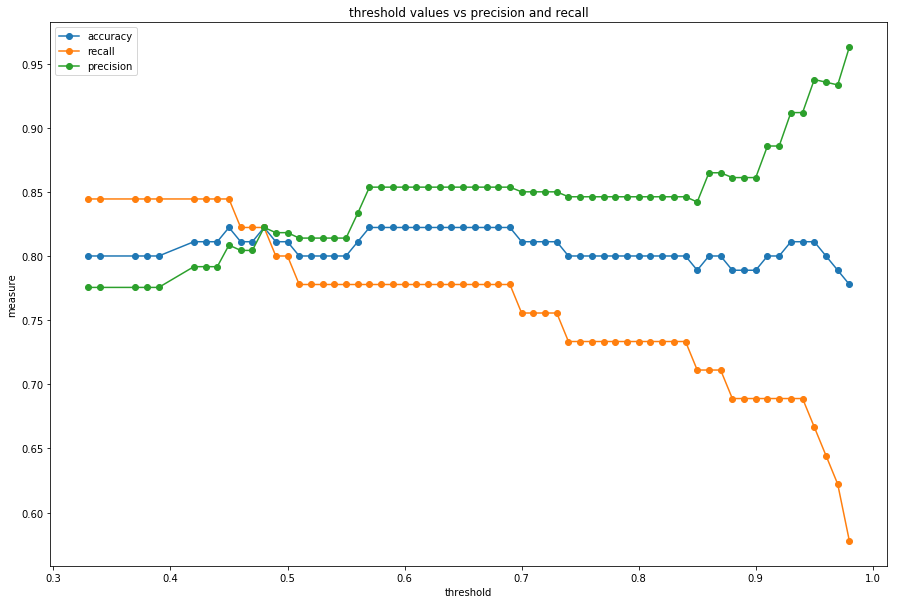

In [18]:
from matplotlib import pyplot as plt

def calculate_performance(validation_data, th=thresh):
    
    att_data = validation_data[Attributes]
    label_data = validation_data[Label]

    X = att_data.values
    Y = label_data.values
    extra_col = np.ones([X.shape[0],1])
    X = np.concatenate((extra_col,X),axis=1)
    
    y_predicted = predict(X)
    y_actual = Y
    
    TP, TN, FP, FN = 0, 0, 0, 0
    i = 0
    for index, row in validation_data.iterrows():
        if y_predicted[i] > th:
            if row[Label] > th:
                TP += 1
            else:
                FP += 1
        else:
            if row[Label] <= th:
                TN += 1
            else:
                FN += 1
        i += 1
    
    acc = float(TP+TN)/(TP+FP+TN+FN)
    pre = 0
    if TP+FP != 0:
        pre = float(TP)/(TP+FP)
    rec = 0
    if TP+FN != 0:
        rec = float(TP)/(TP+FN)
    return acc, pre, rec


accuracy, precision, recall = [], [], []

i = 0
for th in thresh_range:
    a,p,r = calculate_performance(validation_data, th)
    accuracy.append(a)
    precision.append(p)
    recall.append(r)

plt.figure(figsize=(15,10))
plt.plot(thresh_range, accuracy, marker='o', label='accuracy')
plt.plot(thresh_range, recall, marker='o', label='recall')
plt.plot(thresh_range, precision, marker='o', label='precision')
plt.xlabel('threshold')
plt.ylabel('measure')
plt.legend()
plt.title('threshold values vs precision and recall')
plt.show()